## Calculating Fst practice

Practice using Ag1000 data for calculating Fst. Here, Fst is calculated for BFGam and BFCol, using scripts by Alastair Miles using the scikit-allel package. Meant to be using accessible sites, currently trying work out how to do this.

Entirety of script contained in fst_calc.py

In [7]:
import numpy as np
import h5py
import matplotlib.pyplot as plt
%matplotlib inline
import seaborn as sns
sns.set_style('white')
sns.set_style('ticks')
import bcolz
import pandas
import allel; print('scikit-allel', allel.__version__)

scikit-allel 1.2.0


Here I imported data from the AG1000 phase1 ar3, under variation/main/hdf5/x.pass.h5

In [8]:
callset_fn = '../data/phase1/hdf5/ag1000g.phase1.ar3.pass.h5'
callset = h5py.File(callset_fn, mode='r')
callset

<HDF5 file "ag1000g.phase1.ar3.pass.h5" (mode r)>

In [9]:
##set chromosome to work with
chrom = '3L'
# load all variant positions
pos_all = allel.SortedIndex(callset[chrom]['variants']['POS'])
pos_all

0,1,2,3,4,...,9643188,9643189,9643190,9643191,9643192
9790,9798,9812,9818,9829,...,41956532,41956537,41956541,41956551,41956556


In [10]:
##change to genotype data 
genotype_all = allel.GenotypeChunkedArray(callset[chrom]['calldata']['genotype'])
genotype_all

<GenotypeChunkedArray shape=(9643193, 765, 2) dtype=int8 chunks=(6553, 10, 2)
   nbytes=13.7G cbytes=548.0M cratio=25.7
   compression=gzip compression_opts=3
   values=h5py._hl.dataset.Dataset>

In [11]:
##get sample metadata
df_samples = pandas.read_csv('../data/phase1/hdf5/samples.meta.txt', sep='\t', index_col='index')
df_samples.head()

,ox_code,src_code,sra_sample_accession,population,country,region,contributor,contact,year,m_s,sex,n_sequences,mean_coverage,latitude,longitude
index,,,,,,,,,,,,,,,
0,AB0085-C,BF2-4,ERS223996,BFS,Burkina Faso,Pala,Austin Burt,Sam O'Loughlin,2012,S,F,89905852,28.01,11.150,-4.235
1,AB0087-C,BF3-3,ERS224013,BFM,Burkina Faso,Bana,Austin Burt,Sam O'Loughlin,2012,M,F,116706234,36.76,11.233,-4.472
2,AB0088-C,BF3-5,ERS223991,BFM,Burkina Faso,Bana,Austin Burt,Sam O'Loughlin,2012,M,F,112090460,23.30,11.233,-4.472
3,AB0089-C,BF3-8,ERS224031,BFM,Burkina Faso,Bana,Austin Burt,Sam O'Loughlin,2012,M,F,145350454,41.36,11.233,-4.472
4,AB0090-C,BF3-10,ERS223936,BFM,Burkina Faso,Bana,Austin Burt,Sam O'Loughlin,2012,M,F,105012254,34.64,11.233,-4.472


In [12]:
##choose populations
pop1 = 'BFS'
pop2 = 'BFM'
n_samples_pop1 = np.count_nonzero(df_samples.population == pop1)
n_samples_pop2 = np.count_nonzero(df_samples.population == pop2)
print(pop1, n_samples_pop1, pop2, n_samples_pop2)

BFS 81 BFM 69


In [13]:
##compute allele counts
# dictionary mapping population names to sample indices
subpops = {
    pop1: df_samples[df_samples.population == pop1].index,
    pop2: df_samples[df_samples.population == pop2].index,
}
# allele counts
acs = genotype_all.count_alleles_subpops(subpops)
acs

<AlleleCountsChunkedTable shape=(9643193,) dtype=[('BFM', '<i4', (4,)), ('BFS', '<i4', (4,))]
   nbytes=294.3M cbytes=33.7M cratio=8.7
   values=allel.chunked.storage_zarr.ZarrTable>

In [14]:
##filter out non-segregating variants and multiallelic variants
acu = allel.AlleleCountsArray(acs[pop1][:] + acs[pop2][:])
flt = acu.is_segregating() & (acu.max_allele() == 1)
print('retaining', np.count_nonzero(flt), 'SNPs')

pos = pos_all.compress(flt)
ac1 = allel.AlleleCountsArray(acs[pop1].compress(flt, axis=0)[:, :2])
ac2 = allel.AlleleCountsArray(acs[pop2].compress(flt, axis=0)[:, :2])
genotype = genotype_all.compress(flt, axis=0)
genotype

retaining 4495197 SNPs


<GenotypeChunkedArray shape=(4495197, 765, 2) dtype=int8 chunks=(2195, 765, 2)
   nbytes=6.4G cbytes=517.7M cratio=12.7
   compression=blosc compression_opts={'cname': 'lz4', 'clevel': 5, 'shuffle': 1, 'blocksize': 0}
   values=zarr.core.Array>

Now to acutally calculate Fst

In [15]:
##weir-cockerham
# sample indices for population 1
pop1_idx = subpops[pop1]
# sample indices for population 2
pop2_idx = subpops[pop2]
a, b, c = allel.weir_cockerham_fst(genotype, subpops=[pop1_idx, pop2_idx], max_allele=1)
snp_fst_wc = (a / (a + b + c))[:, 0]
snp_fst_wc

array([-0.00100123, -0.00666703,  0.00255152, ..., -0.00100123,
        0.00117408, -0.00100123])

In [16]:
##hudson
num, den = allel.hudson_fst(ac1, ac2)
snp_fst_hudson = num / den
snp_fst_hudson

array([ 0.        , -0.00671141,  0.00177167, ...,  0.        ,
        0.        ,  0.        ])

And plot them against each other to assess similarity of assessment

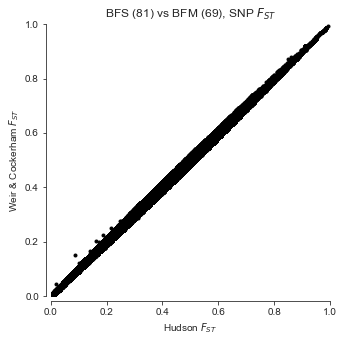

In [17]:
##plot weir-cockram vs hudson
fig, ax = plt.subplots(figsize=(5, 5))
sns.despine(ax=ax, offset=5)
ax.plot(snp_fst_hudson, snp_fst_wc, color='k', marker='.', linestyle=' ')
ax.set_xlim(0, 1)
ax.set_ylim(0, 1)
ax.set_xlabel('Hudson $F_{ST}$')
ax.set_ylabel('Weir & Cockerham $F_{ST}$')
ax.set_title('%s (%s) vs %s (%s), SNP $F_{ST}$' % (pop1, n_samples_pop1, pop2, n_samples_pop2));

Now compute chromosome averages

In [23]:
##weir-cochram
fst_wc, se_wc, vb_wc, _ = allel.blockwise_weir_cockerham_fst(genotype, subpops=[pop1_idx, pop2_idx], blen=10000, max_allele=1)
print('%.04f +/- %.04f (Weir & Cockerham)' % (fst_wc, se_wc))

0.0529 +/- 0.0039 (Weir & Cockerham)


In [19]:
##hudson
fst_hudson, se_hudson, vb_hudson, _ = allel.blockwise_hudson_fst(ac1, ac2, blen=10000)
print('%.04f +/- %.04f (Hudson)' % (fst_hudson, se_hudson))

0.0530 +/- 0.0040 (Hudson)


Now to test importance of SNP ascertation


In [21]:
##define function
def compute_fst(ac1, ac2, scheme):
    
    if scheme == 'first':
        loc_asc = ac1.is_segregating()
    elif scheme == 'second':
        loc_asc = ac2.is_segregating()
    elif scheme == 'either':
        loc_asc = ac1.is_segregating() | ac2.is_segregating()
    elif scheme == 'both':
        loc_asc = ac1.is_segregating() & ac2.is_segregating()    
    n_snps = np.count_nonzero(loc_asc)
    
    ac1 = ac1.compress(loc_asc, axis=0)
    ac2 = ac2.compress(loc_asc, axis=0)
    
    fst, se, _, _ = allel.blockwise_hudson_fst(ac1, ac2, blen=10000)
    
    print('%.04f +/- %.04f (using %s SNPs segregating in %s population)' % (fst, se, n_snps, scheme))

##use function
for scheme in 'first', 'second', 'either', 'both':
    compute_fst(ac1, ac2, scheme)

0.0548 +/- 0.0050 (using 3177964 SNPs segregating in first population)
0.0503 +/- 0.0041 (using 2671158 SNPs segregating in second population)
0.0530 +/- 0.0040 (using 4495197 SNPs segregating in either population)
0.0521 +/- 0.0063 (using 1353925 SNPs segregating in both population)


Now to plot Fst over the chromosome, to examine how it changes over location

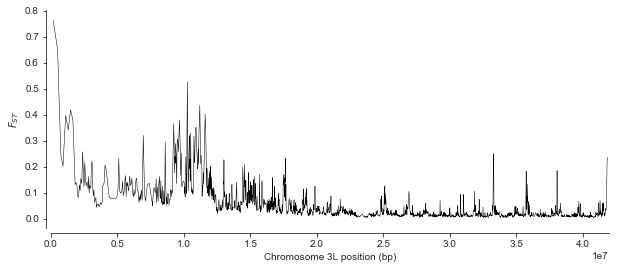

In [22]:
##define function
def plot_fst(ac1, ac2, pos, blen=2000):
    
    fst, se, vb, _ = allel.blockwise_hudson_fst(ac1, ac2, blen=blen)
    
    # use the per-block average Fst as the Y coordinate
    y = vb
    
    # use the block centres as the X coordinate
    x = allel.moving_statistic(pos, statistic=lambda v: (v[0] + v[-1]) / 2, size=blen)
    
    # plot
    fig, ax = plt.subplots(figsize=(10, 4))
    sns.despine(ax=ax, offset=5)
    ax.plot(x, y, 'k-', lw=.5)
    ax.set_ylabel('$F_{ST}$')
    ax.set_xlabel('Chromosome %s position (bp)' % chrom)
    ax.set_xlim(0, pos.max())
    
##plot function
plot_fst(ac1, ac2, pos)


Now that this has been developed for -2- populations at -all- sites, to append to look at -3- populations at -accessible- sites